#### Extract patches from data_processedv0 (WSI) and make data_processedv4 with subfolder named images and masks folder using sliding window technique

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import os
import skimage.draw
import numpy as np
from tqdm import tqdm
import cv2
import random

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')



def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)
        
        
label_map = {'Epithelial':1,
             'Lymphocyte':2,
             'Macrophage':4,
             'Neutrophil':3,
            }


# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Directory of images to run detection on
IMAGES_DEST =  os.path.join(ROOT_DIR, "dataset", "data_processedv0", "images/")
MASKS_DEST = os.path.join(ROOT_DIR, "dataset", "data_processedv0", "masks/")



# Make new folders

IMAGES_DEST_v1 =  os.path.join(ROOT_DIR, "dataset", "data_processedv4", "images/")
MASKS_DEST_v1 = os.path.join(ROOT_DIR, "dataset", "data_processedv4", "masks/")

print(IMAGES_DEST_v1)
print(MASKS_DEST_v1)

# Create folders
create_directory(IMAGES_DEST_v1)
create_directory(MASKS_DEST_v1)

/home/hasib/hasib/MoNuSAC-ISBI-2020/dataset/data_processedv4/images/
/home/hasib/hasib/MoNuSAC-ISBI-2020/dataset/data_processedv4/masks/


In [2]:
#try:
#  # %tensorflow_version only exists in Colab.
#  %tensorflow_version 2.x
#except Exception:
#  pass

In [3]:
def pad(im, desired_size = 900):
    
    """
    Pad input image.
    Args:
        im (np.array): Input image numpy array
    Returns:
        new_im: Padded image array
    """
    
    old_size = im.shape[:2] # old_size is in (height, width) format
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    
    return new_im




def pad(img, pad_size=64):
    """
    Load image from a given path and pad it on the sides, so that eash side is divisible by 64 (network requirement)
    if pad = True:
        returns image as numpy.array, tuple with padding in pixels as(x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    else:
        returns image as numpy.array
    """

    if pad_size == 0:
        return img

    height, width = img.shape[:2]

    if height % pad_size == 0:
        y_min_pad = 0
        y_max_pad = 0
    else:
        y_pad = pad_size - height % pad_size
        y_min_pad = int(y_pad / 2)
        y_max_pad = y_pad - y_min_pad

    if width % pad_size == 0:
        x_min_pad = 0
        x_max_pad = 0
    else:
        x_pad = pad_size - width % pad_size
        x_min_pad = int(x_pad / 2)
        x_max_pad = x_pad - x_min_pad

    img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad, x_min_pad, x_max_pad, cv2.BORDER_REFLECT_101)

    return img, (x_min_pad, y_min_pad, x_max_pad, y_max_pad)



def unpad(img, pads):
    """
    img: numpy array of the shape (height, width)
    pads: (x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    @return padded image
    """
    (x_min_pad, y_min_pad, x_max_pad, y_max_pad) = pads
    height, width = img.shape[:2]

    return img[y_min_pad:height - y_max_pad, x_min_pad:width - x_max_pad]



def read_nuclei(path):
    "read raw data"

    # Load 4-channel image
    img = skimage.io.imread(path)
    
    # input image
    if len(img.shape) > 2:
        img = img[:,:,:3]
    # mask
    else:
        # do nothing
        pass
        
    return img



def save_nuclei(path, img):
    "save image"
    skimage.io.imsave(path, img)

    
def sliding_window(image, step, window):
    x_loc = []
    y_loc = []
    cells = []
    
    for y in range(0, image.shape[0], step):
        for x in range(0, image.shape[1], step):
            cells.append(image[y:y + window[1], x:x + window[0]])
            x_loc.append(x)
            y_loc.append(y)
    return x_loc, y_loc, cells


def extract_patches(image, step, patch_size):
    
    patches = []
    
    # Get locations
    x_pos, y_pos, cells = sliding_window(image, step, (patch_size[0], patch_size[1]))

    for (x, y, cell) in zip(x_pos, y_pos, cells):

        # Get patch
        patch = image[y:y + patch_size[0], x:x + patch_size[0]]

        # Get size
        raw_dim = (patch.shape[1], patch.shape[0]) # W, H
        #print(raw_dim)
        #print(patch.shape)


        if raw_dim != (patch_size[0], patch_size[1]):

            # Resize to 64x64
            #patch = cv2.resize(patch, (64, 64), interpolation = cv2.INTER_AREA)
            patch, pad_locs = pad(patch, pad_size=patch_size[0])
            
            
            # Do stuffffff
            patches.append(patch)
        
        else:

            # Do stuffffff
            patches.append(patch)
    
    patches = np.array(patches)
    
    return patches

Index:  16
(468, 532, 3) (468, 532)
Ground truth classes:  [0 1 2]


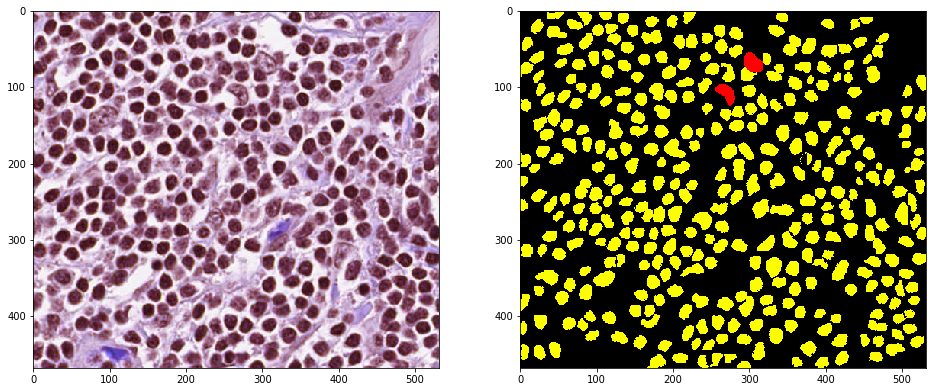

In [14]:
# Load a random image from the images folder
image_fns = sorted(next(os.walk(IMAGES_DEST))[2])
gt_fns = sorted(next(os.walk(MASKS_DEST))[2])


idx = random.randrange(len(image_fns)) # 94 
print("Index: ", idx)


image = skimage.io.imread(os.path.join(IMAGES_DEST, image_fns[idx]))
gt = skimage.io.imread(os.path.join(MASKS_DEST, gt_fns[idx]))

assert image.shape[:2] == gt.shape, "Wrong image or ground truth!"
assert image.dtype == gt.dtype, "Wrong data types!"

print(image.shape, gt.shape)

val1 = gt.flatten()
print("Ground truth classes: ", np.unique(val1))

#label_map = {'Epithelial':1,
#             'Lymphocyte':2,
#             'Macrophage':4,
#             'Neutrophil':3,
#            }

# Stolen from https://stackoverflow.com/questions/16834861/create-own-colormap-using-matplotlib-and-plot-color-scale 
norm=plt.Normalize(0,4) # 5 classes including BG
map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])
#map_name = 'magma'

f, axarr = plt.subplots(1,2, figsize=(16,16))

# idx = 94 all classes
axarr[0].imshow(image, cmap=map_name, norm=norm)
axarr[1].imshow(gt, cmap=map_name, norm=norm)

#### Extract patches from a single image and mask

In [15]:
img_patches = None
gt_patches = None

patch_size = (96, 96)
step = 16  
img_patches = extract_patches(image, step, patch_size)
gt_patches = extract_patches(gt, step, patch_size)

print('Patches shape: {}, {}'.format(img_patches.shape, gt_patches.shape))

Patches shape: (1020, 96, 96, 3), (1020, 96, 96)


Patch mask mean: 0.6707899305555556
Patch mask mean: 0.6588541666666666
Patch mask mean: 0.0
Patch mask mean: 0.6686197916666666
Patch mask mean: 0.6499565972222222
Patch mask mean: 0.5583767361111112
Patch mask mean: 0.5490451388888888
Patch mask mean: 0.6961805555555556
Patch mask mean: 0.0
Patch mask mean: 0.6178385416666666


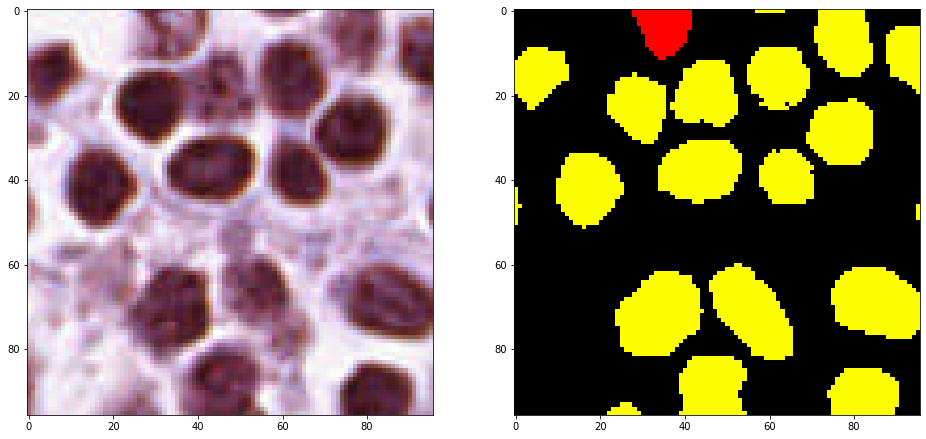

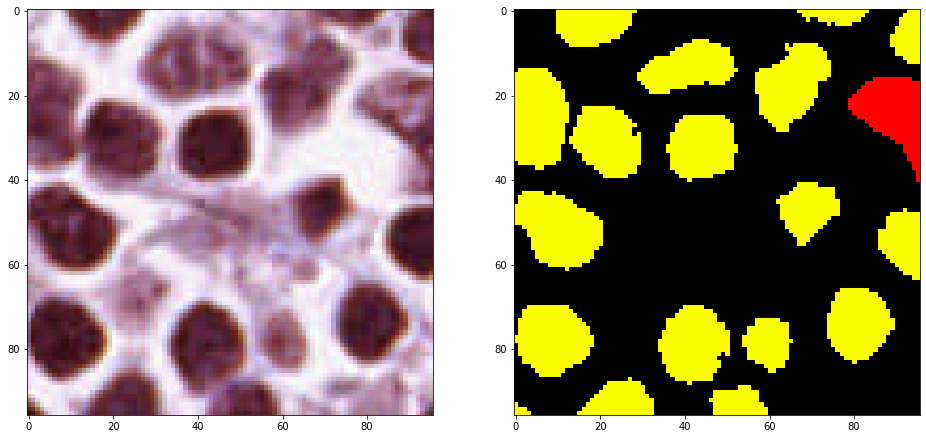

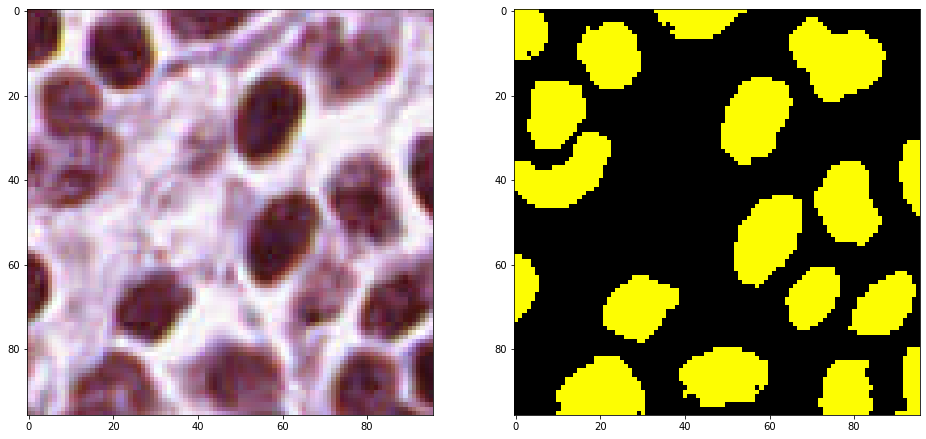

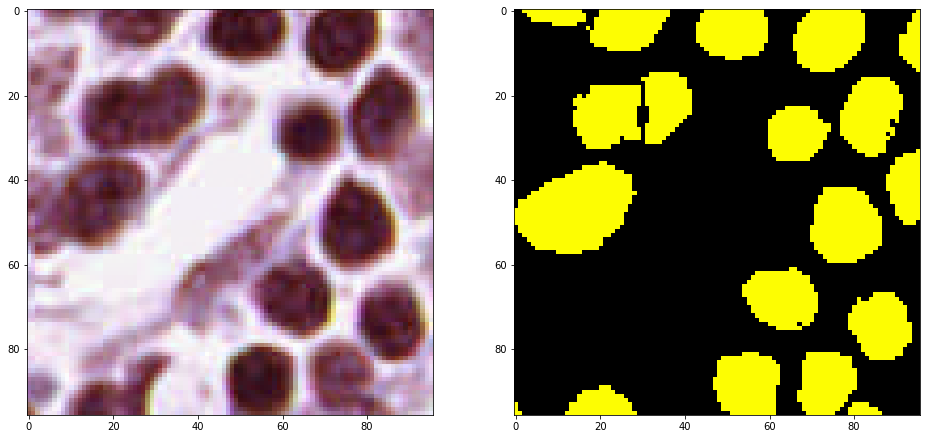

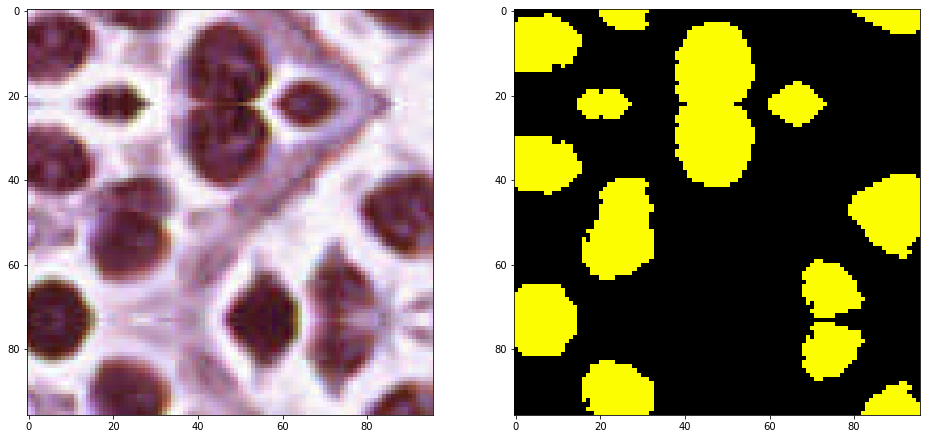

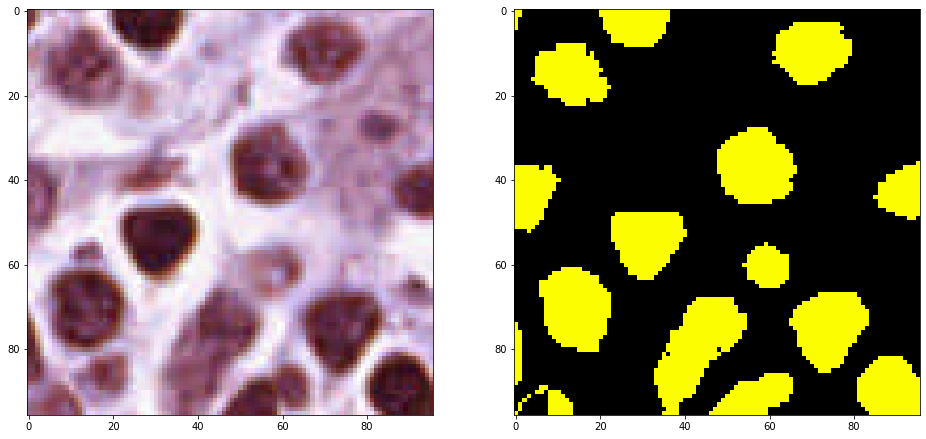

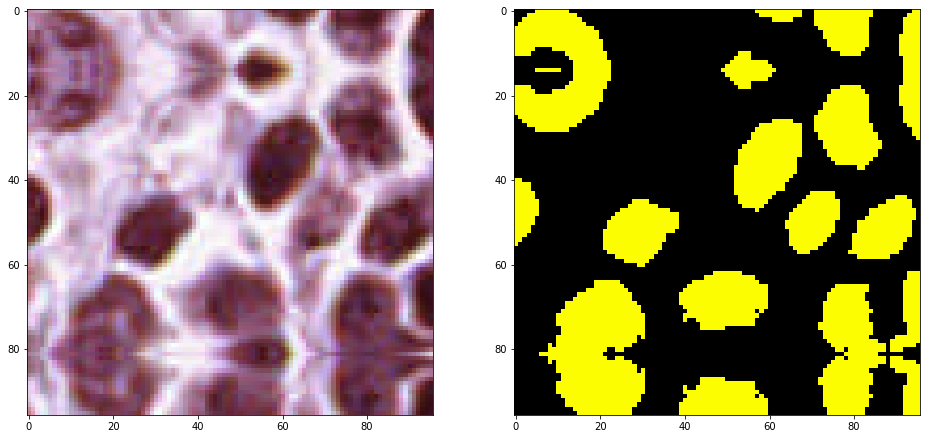

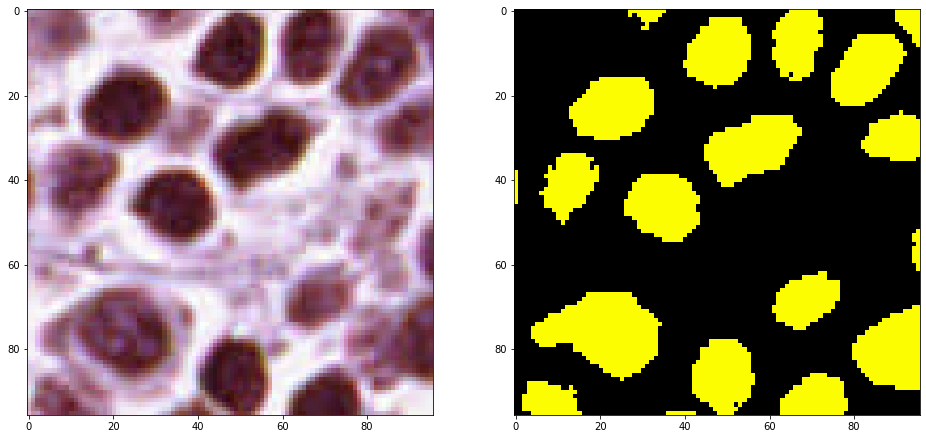

In [16]:
# Sanity check

def process(image, mask):
    f, axarr = plt.subplots(1,2, figsize=(16, 16))
    axarr[0].imshow(image, cmap=map_name, norm=norm)
    axarr[1].imshow(mask, cmap=map_name, norm=norm)

    
    
idxs = [random.randrange(len(img_patches)) for x in range(10)] 
for img, msk in zip(img_patches[idxs], gt_patches[idxs]):
    print("Patch mask mean:", np.mean(msk))
    
    # Set threshold for mask
    if np.mean(msk) < 0.099:
        pass
    
    else:
        process(img, msk)

#### Extract patches and save

In [17]:
# Patch size and stride step
patch_size = (96, 96)
step = 16

# Iterate over all image and masks
ct=0

for img_path, gt_path in tqdm(zip(image_fns[:], gt_fns[:])):
    
    #print(img_path, gt_path)
    
    # Read image and ground truth
    image = skimage.io.imread(os.path.join(IMAGES_DEST, img_path))
    gt = skimage.io.imread(os.path.join(MASKS_DEST, gt_path))
    
    # Extract patches
    img_patches = extract_patches(image, step, patch_size)
    gt_patches = extract_patches(gt, step, patch_size)

    for im, msk in zip(img_patches, gt_patches):
        
        if np.mean(msk) < 0.099:
            pass
        
        else:
            # Save image patch 
            save_nuclei(IMAGES_DEST_v1 + "{}.png".format(ct), im)
            # Save mask patch
            save_nuclei(MASKS_DEST_v1 + "{}.png".format(ct), msk)
            ct+=1
        
    image = None
    gt = None
    img_patches = None
    gt_patches = None

209it [11:20,  3.25s/it]


### Check image-mask order

In [8]:
image_fns = sorted(next(os.walk(IMAGES_DEST_v1))[2])
gt_fns = sorted(next(os.walk(MASKS_DEST_v1))[2])

image_fns[:5], gt_fns[:5]

(['0.png', '1.png', '10.png', '100.png', '1000.png'],
 ['0.png', '1.png', '10.png', '100.png', '1000.png'])

### Display some image-masks

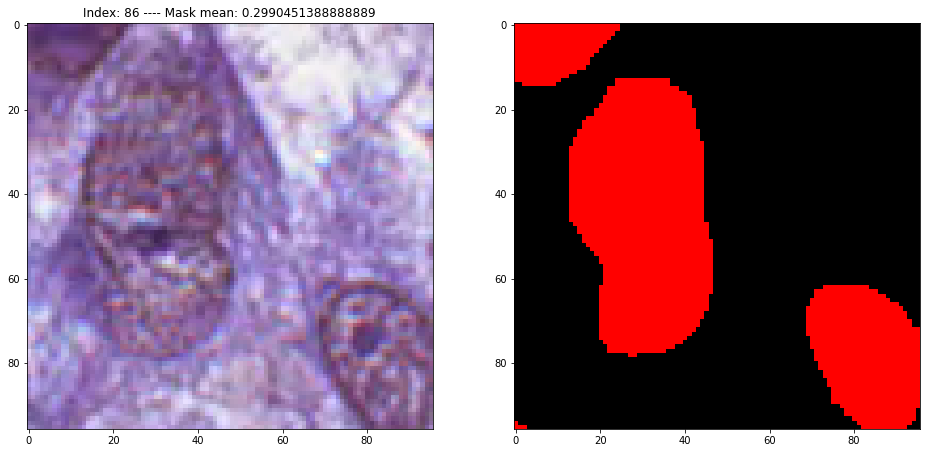

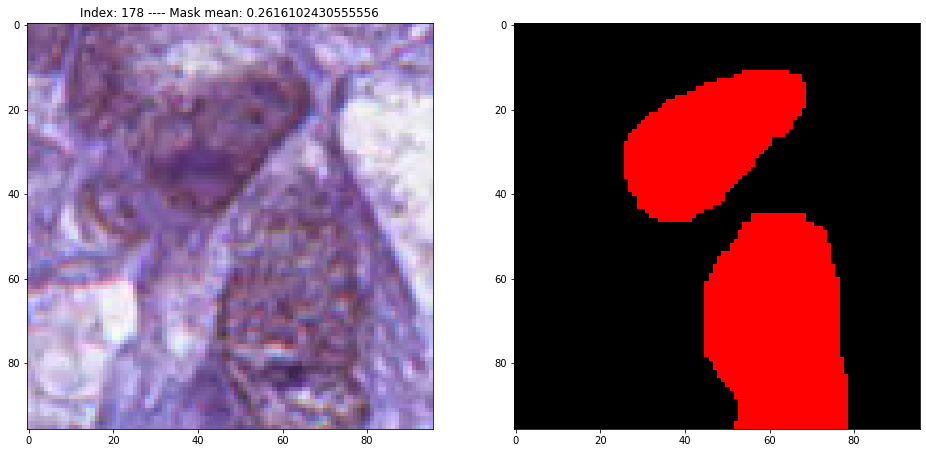

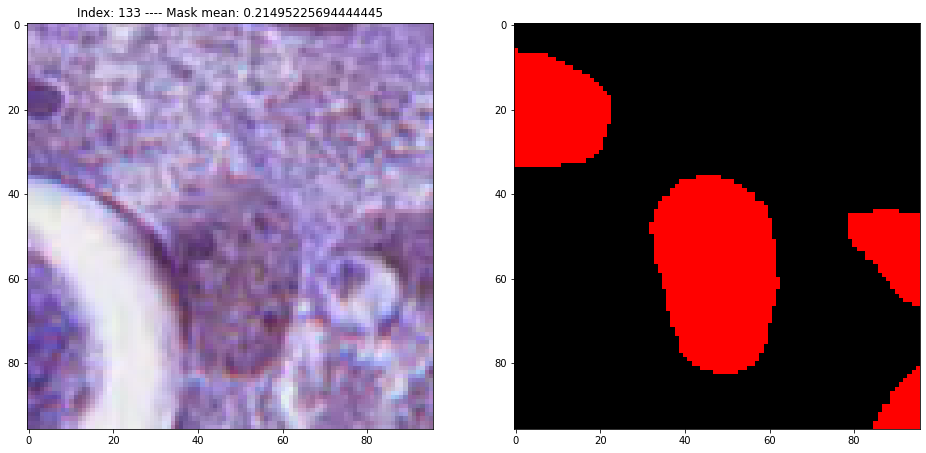

In [30]:
def process(image, mask, idx):
    f, axarr = plt.subplots(1,2, figsize=(16, 16))
    
    # Compute mean of mask
    axarr[0].set_title("Index: {} ---- Mask mean: {}".format(idx, np.mean(mask)))
    
    axarr[0].imshow(image, cmap=map_name, norm=norm)
    axarr[1].imshow(mask, cmap=map_name, norm=norm)

#label_map = {'Epithelial':1,
#             'Lymphocyte':2,
#             'Macrophage':4,
#             'Neutrophil':3,
#            }


count = 3
for i in range(count):
    
    idx = random.randrange(len(image_fns))
    
    image = skimage.io.imread(os.path.join(IMAGES_DEST_v1, image_fns[idx]))
    gt = skimage.io.imread(os.path.join(MASKS_DEST_v1, gt_fns[idx]))
    
    assert image.shape[:2] == gt.shape, "Wrong image or ground truth!"
    assert image.dtype == gt.dtype, "Wrong data types!"
    process(image, gt, idx)

### Split data_processedv4 into PATCH LEVEL train val and store in data_processedv5

In [11]:
IN_FOLDER = os.path.join(ROOT_DIR, "dataset", "data_processedv4") # sliding window patches
OUT_FOLDER = os.path.join(ROOT_DIR, "dataset", "data_processedv5")
IN_FOLDER, OUT_FOLDER

('/home/hasib/hasib/MoNuSAC-ISBI-2020/dataset/data_processedv4',
 '/home/hasib/hasib/MoNuSAC-ISBI-2020/dataset/data_processedv5')

In [12]:
import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
split_folders.ratio(IN_FOLDER, output=OUT_FOLDER, seed=1337, ratio=(.8, .2)) # default values

Copying files: 119394 files [00:08, 13570.59 files/s]
